In [1]:
import pandas as pd
dfRst = pd.read_csv('restaurant_updated.csv')

C:\Users\kevin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,6,7,8,9,16,19,22,28,29,31,39,44,49,50,53,63,65,67,71,77,83,85,90,93,98,101,103) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
dfRstWI = dfRst[(dfRst['state']=='NV')] # change this to NV, WI, or AZ based on whether you're interested in 

In [3]:
from sklearn.cluster import KMeans
# include location based recommendation 
# first we will use elbow method to get the appropriate number of clusters

# Elbow method to determine the number of K in Kmeans Clustering
coords = dfRstWI[['longitude','latitude']]

distortions = []
K = range(1,25)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)

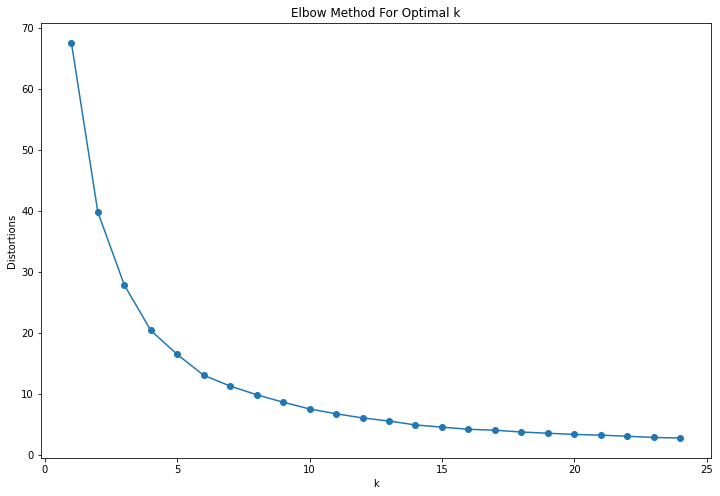

In [4]:
# plot the results
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow.png')
plt.show()

In [5]:
# so optimal number of cluster is 5 for the location system
# we will now filter out and recommend restaurants in NV based on where you are located
kmeans1 = KMeans(n_clusters=5, init='k-means++')
kmeans1.fit(coords)
y1 = kmeans1.labels_
dfRstWI['cluster'] = kmeans1.predict(dfRstWI[['longitude','latitude']])

<ipython-input-5-b6c3f39ebb59>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfRstWI['cluster'] = kmeans1.predict(dfRstWI[['longitude','latitude']])


In [6]:
# now there is a new column called cluster that will identify which part cluster you are based on location
dfRstWI.head()

,Unnamed: 0,business_id,attributes.Ambience.divey,attributes.Dietary.Restrictions.vegan,attributes.Happy.Hour,hours.Thursday.open,attributes.Order.at.Counter,attributes.Hair.Types.Specialized.In.africanamerican,attributes.Hair.Types.Specialized.In.kids,attributes.BYOB,...,attributes.Hair.Types.Specialized.In.curly,attributes.Good.For.Groups,neighborhoods,attributes.Open.24.Hours,attributes.Ambience.romantic,attributes.Hair.Types.Specialized.In.perms,attributes.Music.jukebox,attributes.Ambience.upscale,population,cluster
1907,4823,IjcKyB-LUnev2iapzyJ11w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2267000.0,0
1908,4824,Y3jVDgLRULH52M4_fXQOug,False,NaN,NaN,NaN,True,NaN,NaN,NaN,...,NaN,True,NaN,NaN,False,NaN,NaN,False,2267000.0,2
1909,4826,gfamsLvfcxwJ8cS1i7WCJg,NaN,NaN,NaN,6:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2267000.0,2
1910,4827,EC1kiRed8UwOGX6Ftqc9Tg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2267000.0,2
1911,4828,CwTYM1-zs80BB1AWJrWmxQ,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,NaN,NaN,False,NaN,NaN,False,2267000.0,2


In [7]:
# now make content based recommendation
# Maricopa County, AZ, Dan County, WI, or Clark County, NV.
dfRstWI['categories'] = dfRstWI['categories'].fillna('')
dfRstWI = dfRstWI.drop_duplicates(subset='name')

<ipython-input-7-1fe8c3d57a2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfRstWI['categories'] = dfRstWI['categories'].fillna('')


In [8]:
dfRstWI = dfRstWI.reset_index(drop=True)

In [9]:
# preprocessing step
dfRstWI['categories'] = dfRstWI['categories'].replace({";": " "}, regex=True)
dfRstWI.categories = dfRstWI.categories.str.strip()
dfRstWI.name = dfRstWI.name.str.strip()
comb_frame = dfRstWI['categories']

In [10]:
# Create word vectors from combined frames
# Make sure to make necessary imports
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(comb_frame)

In [11]:
# true_k, we have 31 clusters
# the more clusters you have, the more different categories you will have
# due to computing, we will just stick to 45 clusters for now.
true_k = 31
# Running model with 15 different centroid 
# initializations & maximum iterations are 500
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=15)
model.fit(X)

KMeans(max_iter=500, n_clusters=31, n_init=15)

In [12]:
# check if the clusters are appropriate based on the categories
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 chinese
 restaurants
 szechuan
 taiwanese
 seafood
 vegetarian
 diners
 mexican
 cuban
 event
 entertainment
 estate
 ethiopian
 ethnic
 extensions
Cluster 1:
 brunch
 breakfast
 restaurants
 american
 traditional
 new
 cafes
 food
 sandwiches
 burgers
 diners
 bakeries
 delis
 steakhouses
 bagels
Cluster 2:
 arts
 entertainment
 shopping
 automotive
 stations
 gas
 service
 music
 stores
 venues
 bars
 food
 nightlife
 fashion
 department
Cluster 3:
 tea
 coffee
 food
 cafes
 bakeries
 desserts
 brunch
 breakfast
 restaurants
 bagels
 sandwiches
 bubble
 bars
 rooms
 donuts
Cluster 4:
 sushi
 japanese
 bars
 restaurants
 steakhouses
 korean
 buffets
 chinese
 seafood
 hawaiian
 lounges
 pot
 nightlife
 sum
 dim
Cluster 5:
 desserts
 food
 bakeries
 shaved
 ice
 specialty
 restaurants
 hawaiian
 cupcakes
 pizza
 italian
 caterers
 sandwiches
 vendors
 street
Cluster 6:
 mexican
 restaurants
 seafood
 vegan
 vegetarian
 cafes
 yogurt
 ethiopian
 educat

In [13]:
# store sum of square errors
sse = {}
# Looping over multiple values of k from 1 to 40
for k in range(1, 40):
    kmeans2 = KMeans(n_clusters=k, init='k-means++', max_iter=100).fit(X)
    comb_frame["clusters"] = kmeans2.labels_
    sse[k] = kmeans2.inertia_


<ipython-input-13-6296c3b015f0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_frame["clusters"] = kmeans2.labels_


Text(0, 0.5, 'SSE')

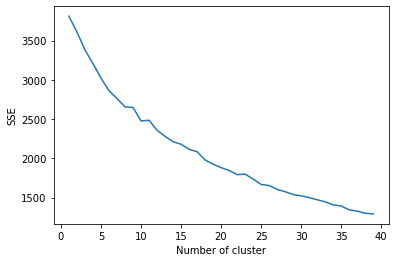

In [14]:
# notice that square sum of errors decreases drastically as cluster increases.
# this means that there is no clear optimal number of clusters based on the SSE
# In general, the more clusters we have, the better because there will be more variety in recommendation 
import matplotlib.pyplot as plt
# Plotting the curve with 'k'-value vs SSE
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

In [15]:
dfRstWI['categories'].shape

(4140,)

In [16]:
def cluster_predict(str_input):
    Y = vectorizer.transform(list(str_input))
    prediction = model.predict(Y)
    return prediction

In [31]:
j = dfRstWI.loc[dfRstWI['name'] == 'Pizza Hut']
m = list(j['categories'])
p = cluster_predict(m)


[7]


In [17]:
# Create new column for storing predicted categories from our trained model.
dfRstWI['ClusterPrediction'] = ""

In [18]:
# Cluster category 
dfRstWI['ClusterPrediction']=dfRstWI.apply(lambda x: cluster_predict(dfRstWI['categories']), axis=0)

In [19]:
# now combine longitude and latitude coordinates with restaurant recommendation
import numpy as np
def rst_rec_sys(str_input, longitude, latitude):

    # match on the basis restaurant name and form whole 'categories' entry out of it.
    temp_df = dfRstWI.loc[dfRstWI['name'] == str_input]
    
    str_input = list(temp_df['categories'])
    
    # Predict category of input string category
    prediction_inp = cluster_predict(str_input)
    prediction_inp = int(prediction_inp)
    # Predict the cluster for longitude and latitude provided
    cluster = kmeans1.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    dfRstWI2 = dfRstWI[dfRstWI['cluster']==cluster]
    
    # Based on the above prediction pick 10 restaurants based on the location and the restaurant content
    # Recommendation Logic is kept super-simple for current implementation.
    # it will also randomly pick 5 samples
    temp_df = dfRstWI2.loc[dfRstWI2['ClusterPrediction'] == prediction_inp]
    temp_df = temp_df.sample(5)
    return temp_df[temp_df['cluster']==cluster].iloc[0:5][['name', 'latitude','longitude']]

In [37]:
rst_rec_sys('Boba City Cafe',-115.1891691,  36.1017316)

,name,latitude,longitude
724,The Coffee Bean & Tea Leaf,36.080287,-115.159272
1475,Teavana,36.127424,-115.170815
743,Al's Donuts,36.108111,-115.136431
3364,Viva Café Espresso Bar,36.172532,-115.197258
3216,Fuel Café,36.110464,-115.154282


In [40]:
rst_rec_sys('', -115.1,  36.2)

,name,latitude,longitude
1208,Lanai Express,36.170764,-115.143526
3983,Saborr,36.240859,-115.078775
2528,The Lunch Box,36.105160,-115.136178
3025,Sports Book Grill,36.092339,-115.174684
91,Carl's Jr Restaurants,36.196200,-115.121018


In [35]:
rst_rec_sys('Great Wall Chinese Restaurant', -115.2398, 38)

,name,latitude,longitude
2368,Dragon Bowl,36.246758,-115.209185
2967,Bangkok 9,36.217763,-115.242392
1660,Imperial Asian Buffet,36.238728,-115.233117
574,Chinese Village Restaurant & Lounge,36.179505,-115.242221
2432,China Wok,36.237905,-115.181957


In [34]:
rst_rec_sys('China Wok', -115.2398, 38)

,name,latitude,longitude
371,Diamond China 2,36.200690,-115.281657
4026,Super No1 Chinese Restaurant,36.263013,-115.180561
2432,China Wok,36.237905,-115.181957
1660,Imperial Asian Buffet,36.238728,-115.233117
2967,Bangkok 9,36.217763,-115.242392


In [33]:
rst_rec_sys('Pho Sing Sing',-115.2891691,  36.0017316)

,name,latitude,longitude
1015,Pho 777,36.042092,-115.278788
3729,Pho Sing Sing,36.126577,-115.225926
3023,Lilly's Thai & Vietnamese Restaurant,36.143300,-115.253540
3507,Pho Pasteur & Grill,36.126508,-115.218285
2118,Pho 87,36.123285,-115.224712


In [32]:
rst_rec_sys('Thai Food To Go',-115.1891691,  36.2017316)

,name,latitude,longitude
3181,Mix Zone Cafe 2,36.196861,-115.262203
3664,Thai Noodles Cafe,36.219111,-115.242881
1037,Thai Basil,36.262339,-115.178170
4084,Siam Thai Kitchen,36.179324,-115.241967
2608,Nittaya's Secret Kitchen,36.198048,-115.282539
